# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察

# [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響 (In[3]~[5], Out[3]~[5]) 
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響 (In[8], Out[8]) 

In [57]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [58]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [59]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestClassifier()
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.242400
Ticket      0.148612
Name        0.131668
Fare        0.127616
Age         0.100867
Cabin       0.076503
Pclass      0.075194
Parch       0.038688
SibSp       0.033881
Embarked    0.024571
dtype: float64

## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

In [60]:
# 高重要性特徵 + 隨機森林
high_feature = list(feats[:5].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8047810703432564

In [62]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8204675388602046

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?

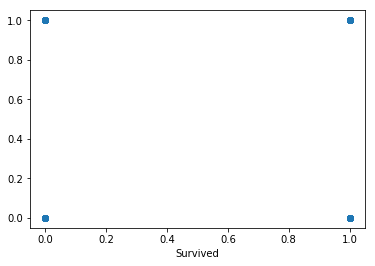

In [63]:
# 觀察重要特徵與目標的分布
# 第一名              
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=train_Y, y=df[feats[:1].index], fit_reg=False)
plt.show()

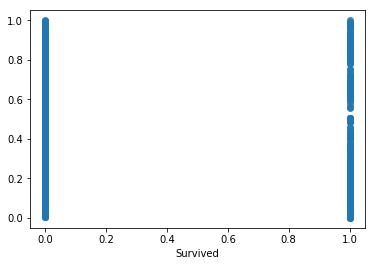

In [64]:
# 第二名       
sns.regplot(x=train_Y, y=df[feats[1:2].index], fit_reg=False)
plt.show()

In [65]:
# 製作新特徵看效果
df["VIPLevel"] = df["Fare"]/(df["Pclass"]+1)
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8160106064748863

In [66]:
# Name不應該影響存活率，刪除Name是算分數是否提升預測率
df2 = df.drop(["Name"], axis=1)
estimator.fit(df2.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df2.columns)
feats = feats.sort_values(ascending=False)
print(feats)
high_feature = list(feats[:5].index)
train_X = MMEncoder.fit_transform(df2[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

Sex         0.217383
Ticket      0.207419
VIPLevel    0.138360
Age         0.137919
Fare        0.110867
Cabin       0.065190
Parch       0.036988
Pclass      0.034688
SibSp       0.031339
Embarked    0.019846
dtype: float64


0.8115476807290765

In [26]:
print(feats)
print(feats[:1].index)

Sex         0.230454
Ticket      0.172468
Name        0.146988
Fare        0.124619
Age         0.105386
Cabin       0.065913
Pclass      0.060004
Parch       0.041875
SibSp       0.034241
Embarked    0.018051
dtype: float64
Index(['Sex'], dtype='object')


In [35]:
# 高重要性特徵 + 隨機森林
high_feature2 = feats[:5].index.drop(["Name"])
train_X = MMEncoder.fit_transform(df[high_feature2])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8137192631925745

In [42]:
print(df["Fare"].dtype, df["Pclass"].dtype)
print(df["Pclass"])

float64 float64
0      1.0
1      0.0
2      1.0
3      0.0
4      1.0
5      1.0
6      0.0
7      1.0
8      1.0
9      0.5
10     1.0
11     0.0
12     1.0
13     1.0
14     1.0
15     0.5
16     1.0
17     0.5
18     1.0
19     1.0
20     0.5
21     0.5
22     1.0
23     0.0
24     1.0
25     1.0
26     1.0
27     0.0
28     1.0
29     1.0
      ... 
861    0.5
862    0.0
863    1.0
864    0.5
865    0.5
866    0.5
867    0.0
868    1.0
869    1.0
870    1.0
871    0.0
872    0.0
873    1.0
874    0.5
875    1.0
876    1.0
877    1.0
878    1.0
879    0.0
880    0.5
881    1.0
882    1.0
883    0.5
884    1.0
885    1.0
886    0.5
887    0.0
888    1.0
889    0.0
890    1.0
Name: Pclass, Length: 891, dtype: float64


Sex         0.198423
Ticket      0.171532
VIPLevel    0.142517
Name        0.122777
Age         0.103652
Fare        0.094462
Cabin       0.057526
Pclass      0.041055
Parch       0.030634
SibSp       0.022306
Embarked    0.015116
dtype: float64